In [1]:
%matplotlib notebook

import os
import yaml
import sys
import datetime
import numpy as np
import json

import keras.backend as K
from keras.models import load_model
import tensorflow as tf
from matplotlib import pyplot as plt

# NeMO-Net specific files 
sys.path.append("./utils/") # Adds higher directory to python modules path.
import NeMO_Layers
from NeMO_Generator import NeMOImageGenerator, ImageSetLoader
from NeMO_CoralData import CoralData
from NeMO_Generator import NeMOImageGenerator
from NeMO_DirectoryIterator import NeMODirectoryIterator
from NeMO_CoralPredict import CoralPredict
from NeMO_losses import charbonnierLoss, keras_lovasz_softmax, categorical_focal_loss

import tensorflow as tf
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

num_cores = 4
num_GPU = 1
num_CPU = 1

global _SESSION
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
_SESSION = tf.Session(config=config)
K.set_session(_SESSION)

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
CoralClasses_config = './config/CoralClasses.json'
with open(CoralClasses_config) as json_file:
    CoralClasses = json.load(json_file)
labelkey = CoralClasses["VedConsolidated_ClassDict"]

DataSource_config = "./config/RefineNet_DataSource.yaml" # Training files info
with open(DataSource_config, 'r') as stream:
    try:
        init_args = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

train_loader = ImageSetLoader(**init_args['image_set_loader']['train'])
val_loader = ImageSetLoader(**init_args['image_set_loader']['val'])
y = train_loader.image_size[1]
x = train_loader.image_size[0]
num_channels = 4

# imgpath = '/home/shared/NeMO-Net Data/KSLOF-CICIA-FIJI/Cicia_Satellite_image_mosaic_KSLOF.tif'
# labelpath = '/home/shared/NeMO-Net Data/KSLOF-CICIA-FIJI/Cicia_habitats_watt_KSLOF.shp'

imgpath = '/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_003.TIF'
labelpath = '/home/shared/NeMO-Net Data/KSLOF-CICIA-FIJI/Cicia_Habitat_classes_raster_KSLOF.tif'

Fiji = CoralData(imagepath = imgpath, labelpath = labelpath, labelkey = CoralClasses["Fiji_ClassDict"], load_type = "raster", shpfile_classname = 'Hab_name')
Fiji.consolidate_classes(newclassdict = CoralClasses["L3_ClassDict"], transferdict = CoralClasses["Fiji2L3_Dict"])
Fiji.consolidate_classes(newclassdict = CoralClasses["VedConsolidated_ClassDict"], transferdict = CoralClasses["L32VedConsolidated_Dict"])

In [3]:
model = load_model('./tmp/RefineMask_Jarrett256_RGB_NIR_spectralshift.h5', custom_objects={'BilinearUpSampling2D':NeMO_Layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss})

ystart = 1186-256
xstart = 4105-256
ylen = 1024
xlen = 1024
image_array = Fiji.image[ystart: ystart+ylen, xstart:xstart+xlen, :]
image_array = np.delete(image_array, [0,3,5,7], 2)

label_array = np.copy(Fiji.labelimage_consolidated[ystart: ystart+ylen, xstart:xstart+xlen])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Row: 0 completed
Row: 128 completed
Row: 256 completed
Row: 384 completed
Row: 512 completed
Row: 640 completed
Row: 768 completed


<IPython.core.display.Javascript object>


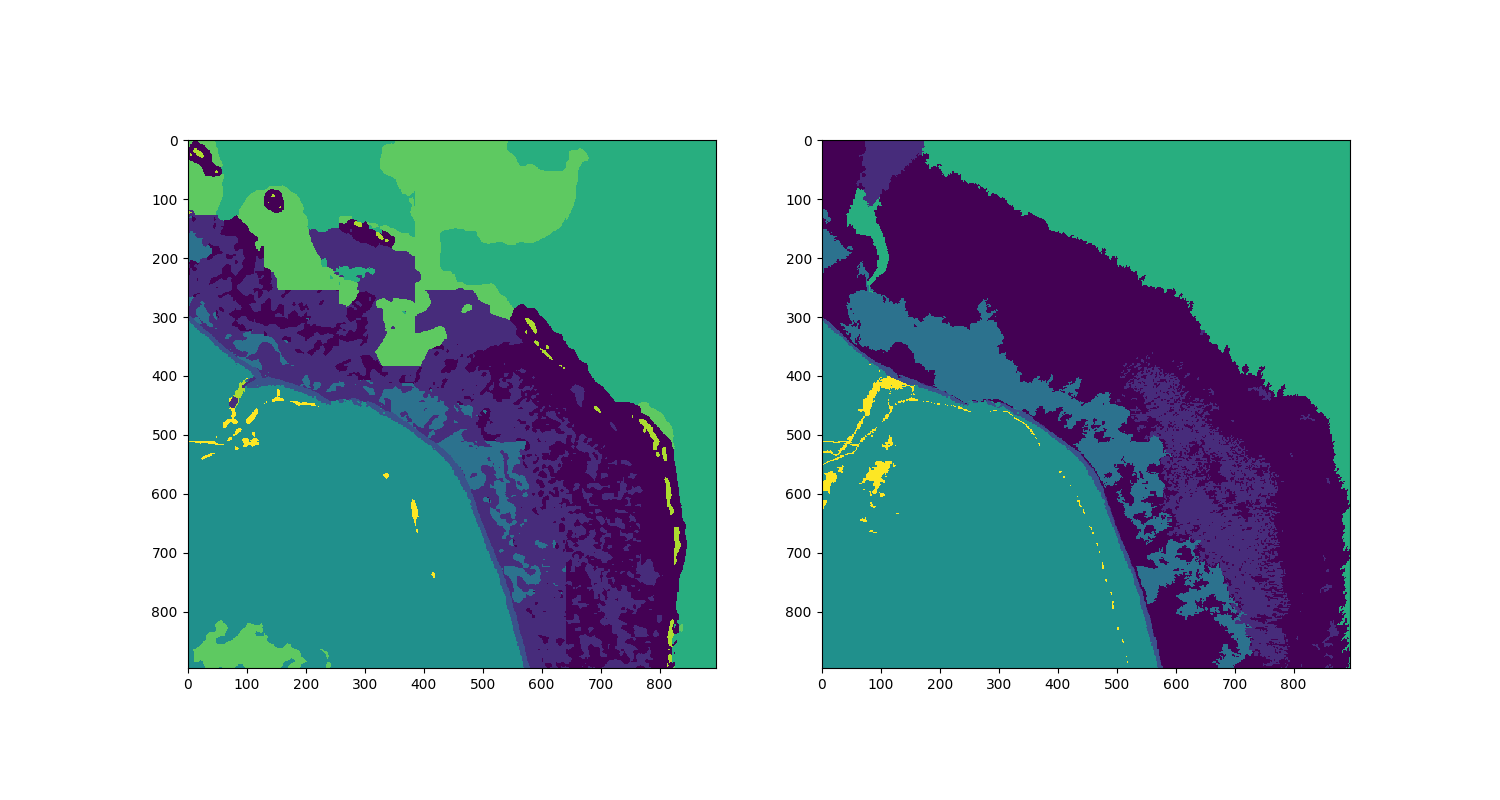

KL-divergence at 0: -5971358.663884007
KL-divergence at 1: -7151422.328518821
KL-divergence at 2: -7335257.966392813
KL-divergence at 3: -7372679.482785862
KL-divergence at 4: -7387629.46125982
KL-divergence at 5: -7397396.192959714
KL-divergence at 6: -7404122.613375822
KL-divergence at 7: -7408650.447219547
KL-divergence at 8: -7412308.10211845
KL-divergence at 9: -7415198.407131382
KL-divergence at 10: -7417737.5123796975
KL-divergence at 11: -7420128.32533221
KL-divergence at 12: -7422029.898971889
KL-divergence at 13: -7423587.762829259
KL-divergence at 14: -7424993.473111898
KL-divergence at 15: -7426206.876001263
KL-divergence at 16: -7427225.813148398
KL-divergence at 17: -7428086.4409827385
KL-divergence at 18: -7428814.436420926
KL-divergence at 19: -7429471.091984816


<IPython.core.display.Javascript object>


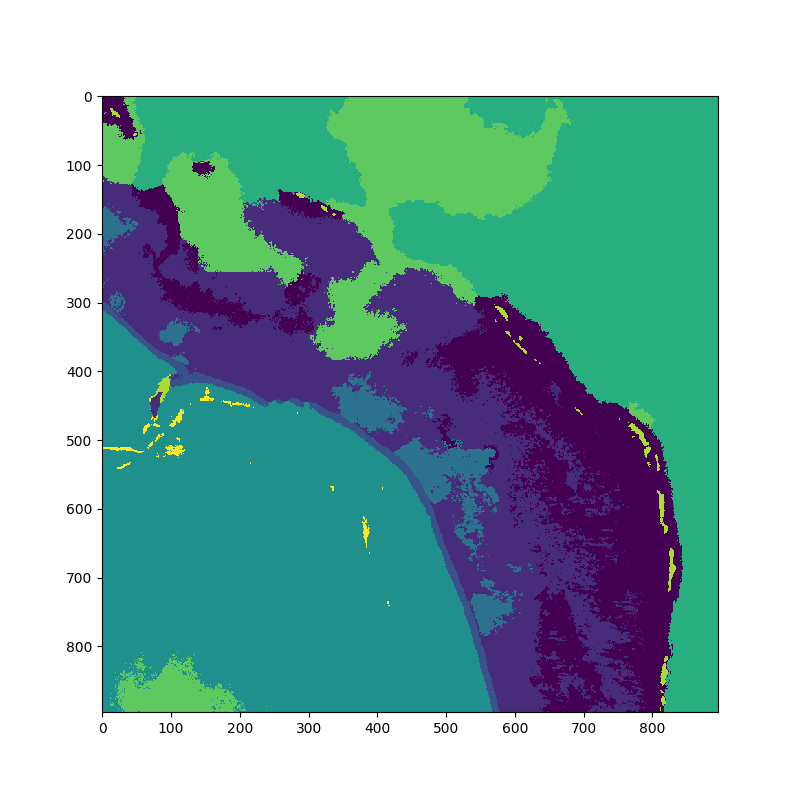

In [4]:
NeMOPredict = CoralPredict(image_array, 
                           labelkey, 
                           label_array = label_array, 
                           patch_size = 256,
                           spacing = (128, 128),
                           predict_size = 128,
                           image_mean=100.0, 
                           image_std = 100.0)
final_predict, prob_predict, label_array = NeMOPredict.predict_on_whole_image(model = model, num_lines = None)

mask_dict = {'Coral': 'Terrestrial vegetation',
            'Sediment': 'Terrestrial vegetation',
            'Beach': 'Terrestrial vegetation',
            'Seagrass': 'Terrestrial vegetation',
            'Deep water': 'Terrestrial vegetation',
            'Wave breaking': 'Terrestrial vegetation'}
final_predict = NeMOPredict.maskimage(final_predict, label_array, mask_dict)

fig = plt.figure(1,figsize=(15,8))
ax = plt.subplot(121)
ax.imshow(final_predict)

ax = plt.subplot(122)
ax.imshow(label_array)

CRF_image = NeMOPredict.CRF(imageprob_array = prob_predict)
fig = plt.figure(2,figsize=(8,8))
ax = plt.subplot(111)
ax.imshow(CRF_image)

plt.show()

In [19]:
n = 1000
probcutoff_dict = {'Sediment': 0.90, 'Coral': 0.85, 'Seagrass': 0.75, 'Deep water': 0.85}
numcutoff_dict = {'Seagrass': 300, 'Clouds': 100}
targetnum_dict = {'Coral': 2000}

hiprob_coords, class_samples = NeMOPredict.identify_hiprobclasses(CRF_image,
                                                                  prob_predict,
                                                                  probcutoff_dict, 
                                                                  numcutoff_dict = numcutoff_dict,
                                                                  targetnum_dict = targetnum_dict,
                                                                  n = 1000)

KNN_classes = ['Sediment', 'Coral', 'Seagrass', 'Deep water']
clf_KNN = NeMOPredict.KNN_Analysis(class_samples = class_samples,
                                   KNN_classes = KNN_classes)

reclassify_dict = {'Coral': ['Coral', 'Sediment', 'Seagrass', 'Deep water'],
                   'Sediment': ['Coral', 'Sediment', 'Seagrass', 'Deep water'],
                   'Seagrass': ['Coral', 'Sediment', 'Seagrass', 'Deep water']}

KNN_predict, KNN_prob = NeMOPredict.apply_KNN(KNN_model = clf_KNN, 
                                              KNN_classes = KNN_classes,
                                              imagepredict_array = CRF_image, 
                                              imageprob_array = prob_predict, 
                                              reclassify_classes = reclassify_dict)


cloud_coords = np.where(CRF_image == NeMOPredict.classes["Clouds"])
repredict_classes_coords = dict((k,hiprob_coords[k]) for k in ('Sediment', 'Coral') if k in hiprob_coords)

class_mean = {}
class_std = {}
offstart = NeMOPredict.offstart
for k, v in repredict_classes_coords.items():
    class_mean[k] = np.mean(NeMOPredict.image_array[offstart + v[0], offstart + v[1], :], 0)
    class_std[k] = np.std(NeMOPredict.image_array[offstart + v[0], offstart + v[1], :], 0)
    print(k, class_mean[k], class_std[k])

final_predict, final_prob = NeMOPredict.cloud_clustering(cloud_coords = cloud_coords,
                                                         distance_multiplier = 5.0,
                                                         dbscan_eps = 5.0,
                                                         dbscan_minsamples = 20,
                                                         repredict_classes_coords = repredict_classes_coords,
                                                         KNN_model = clf_KNN,
                                                         KNN_classes = KNN_classes,
                                                         imagepredict_array = KNN_predict,
                                                         imageprob_array = KNN_prob, 
                                                         verbose = False)

fig = plt.figure(3,figsize=(15,8))
ax = plt.subplot(121)
ax.imshow(np.asarray(np.clip(255/200*NeMOPredict.image_array[NeMOPredict.offstart: ylen - NeMOPredict.offstart, NeMOPredict.offstart: ylen - NeMOPredict.offstart, 2::-1], 0, 255), dtype=np.uint8))

ax = plt.subplot(122)
ax.imshow(final_predict)

Samples of Sediment : 14187
Samples of Coral : 15127
Samples of Seagrass : 8726
Samples of Deep water : 178581
Sediment (1000, 4)
Coral (1000, 4)
Seagrass (1000, 4)
Deep water (1000, 4)
(103643, 4) (103643,) (103643, 4)
(147126, 4) (147126,) (147126, 4)
(20716, 4) (20716,) (20716, 4)
Sediment [124.76456155 119.22963981  66.80794339  12.01012882] [18.31287701 18.67791647  9.44926877  3.99835179]
Coral [110.07063183  95.42505931  50.89926436  11.24000995] [8.18969817 9.90825098 5.97567011 1.32398841]


<IPython.core.display.Javascript object>